# **Model Forecast - Comparison and Improvement**

In [ ]:
#Necessary Pip Installs 
!pip install pmdarima
!pip install prophet
!pip install kats
# !pip install pydlm

In [2]:
#Imports
import pandas as pd
import numpy as np
import math
import itertools
%matplotlib inline

# Load specific forecasting tools
# from statsmodels.tsa.arima_model import ARMA,ARMAResults,ARIMA,ARIMAResults
import statsmodels.api as sm
from matplotlib import pyplot as plt
#ARIMA
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.tools import diff
from pmdarima import auto_arima # for determining ARIMA orders  
from statsmodels.tsa.arima.model import ARIMA
#Prophet
from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric
from prophet.plot import plot_plotly, plot_components_plotly
#KATS
from kats.consts import TimeSeriesData
from kats.detectors.outlier import OutlierDetector
#Bayesian
# from pydlm import dlm, trend, seasonality
#Metrics
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

In [18]:
#Import the Dataset
df = pd.read_excel('/content/drive/MyDrive/Github/m_tech/Datasets/input.xlsx')
df.rename(columns={'SalesVolume':'Values'},inplace=True)

In [ ]:
#Import the Dataset
df = pd.read_excel('/content/drive/MyDrive/Github/m_tech/Datasets/UK_House_Weighted.xlsx')
df.rename(columns={'SalesVolume':'Values'},inplace=True)

In [ ]:
df = pd.read_excel('/content/drive/MyDrive/Github/m_tech/Datasets/tfl-journeys-type.xlsx')
df = df.dropna()

In [ ]:
df = pd.read_excel('/content/drive/MyDrive/Github/m_tech/Datasets/tfl-journeys-type_weighted.xlsx')
df = df.dropna()

In [4]:
metrics_df = pd.DataFrame(columns=['TYPE','ORDER','MAPE','MSE','RMSE','MAE'])

In [5]:
hyper_df = pd.DataFrame(columns=['TYPE','ORDER','MAPE','MSE','RMSE','MAE'])

In [19]:
df.tail()

,Date,Values
316,2021-05-01,57106.0
317,2021-06-01,121727.0
318,2021-07-01,27865.0
319,2021-08-01,30946.0
320,2021-09-01,40929.0


In [20]:
#Remove Outliers
def remove_outliers(df):
  kats_df = df.rename(columns={'Date':'time'})
  ts = TimeSeriesData(kats_df)
  outlier_detector = OutlierDetector(ts, "additive",iqr_mult=2)
  outlier_detector.detector()
  ts_day_outliers_interpolated = outlier_detector.remover(interpolate=True)
  # df_final.interpolate(method="linear", limit_direction="both", inplace=True)
  processed_df = ts_day_outliers_interpolated.to_dataframe()
  processed_df.rename(columns={'time':'Date','y_0':'Values'},inplace=True)
  plot_outliers(outlier_detector,ts,processed_df)
  return processed_df

In [21]:
#Print and Plot outliers
def plot_outliers(outlier_detector,ts,processed_df):
  outlier_detector.detector()
  outliers = outlier_detector.outliers
  print(outliers[0])
  ax = ts.to_dataframe().plot(x="time", y="Values")
  processed_df.plot(x="Date", y="Values", ax=ax)
  plt.legend(labels=["original ts", "ts with removed outliers"])
  plt.show()

[Timestamp('2002-05-01 00:00:00'), Timestamp('2016-03-01 00:00:00'), Timestamp('2020-04-01 00:00:00'), Timestamp('2020-05-01 00:00:00'), Timestamp('2021-02-01 00:00:00'), Timestamp('2021-03-01 00:00:00')]


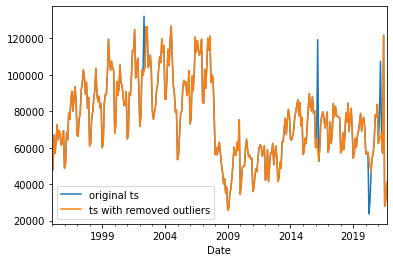

In [22]:
df = remove_outliers(df)

In [17]:
# Exclude pre changepoints data  - Sales Volume
df = df[df['Date']>='2009-01-01']
df = df.reset_index(drop=True)

In [ ]:
df.head()

,Date,Values
0,2009-01-01,25782.0
1,2009-02-01,26660.0
2,2009-03-01,34857.0
3,2009-04-01,37585.0
4,2009-05-01,43500.0


# **ARIMA**

In [23]:
def arima_check(arima_df):
  diff_order = stationarity_check(arima_df)
  if diff_order > 0:
    print('Requires differencing of order: ',diff_order )
  auto_arima_summary = auto_arima(arima_df['Values'], seasonal=False).summary()
  return auto_arima_summary,arima_df

In [24]:
def stationarity_check(st_check_df):
  order = 0
  input_df = st_check_df.copy()
  while True:
    check_stationarity = adf_test(input_df['Values'])
    if not check_stationarity:
      input_df['Values'] = diff(input_df['Values'],k_diff=1)
      input_df = input_df.iloc[1:,:]
      order +=1
      continue
    else:
      break
  return order

In [25]:
#Preprocessing before feeding into the ARIMA models
def arima_preprocess(input_df):
  """
  Pass in the input df returns a dataframe after processing the date field
  """
  input_df['Date'] = pd.DatetimeIndex(input_df['Date'])
  input_df = input_df.groupby('Date').sum()
  #Settting a Monthly frequency and also to the first day of the month
  input_df = input_df.asfreq('MS')
  # input_df = input_df.asfreq('W-Sat')
  return input_df

In [26]:
#Stationarity Check
def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
        return True
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")
        return False

In [27]:
def arima_train(arima_df,model_type,order_tpl,season_tpl,freq):
  # Setting the last 7 months for testing
  model = None
  index = len(arima_df) - 11
  train = arima_df.iloc[:index]
  test = arima_df.iloc[index:]
  if model_type == 'SARIMAX':
    model=sm.tsa.statespace.SARIMAX(arima_df['Values'],order=order_tpl)
    model = sm.tsa.statespace.SARIMAX(arima_df['Values'],  # this is your time series you will input
                                                order=order_tpl,
                                                seasonal_order=season_tpl,
                                                # enforce_stationarity=False,
                                                # enforce_invertibility=False,
                                                freq=freq)
  elif model_type == 'ARIMA':
    model=ARIMA(arima_df['Values'],order=order_tpl)
  results=model.fit()
  start=len(train)
  end=len(train)+len(test)-1
  predictions_SARIMAX = results.predict(start=start, end=end).rename('Predictions')
  test['Predictions'] = predictions_SARIMAX
  return test

# **Common Utils**

In [28]:
#Metrics Evaluation
def metrics(metrics_df,input_df,model_type,order):
  metrics_df = metrics_df.append({'TYPE':model_type,
                                  'ORDER':order,
                                  'MAPE':mean_absolute_percentage_error(input_df['Values'], input_df['Predictions']),
                                  'MSE':mean_squared_error(input_df['Values'], input_df['Predictions']),
                                  'RMSE':rmse(input_df['Values'], input_df['Predictions']),
                                  'MAE':mean_absolute_error(input_df['Values'], input_df['Predictions'])
                                  }
                                 ,ignore_index=True)
  return metrics_df

In [29]:
def pred_plot(plot_df):
  title = 'Forecast'
  ylabel='Values'
  xlabel = 'Date'
  ax = plot_df['Values'].plot(legend=True,figsize=(12,6),title=title)
  plot_df['Predictions'].plot(legend=True)
  ax.autoscale(axis='x',tight=True)
  ax.set(xlabel=xlabel, ylabel=ylabel);

In [30]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(input_df, model_type,hyper_df):
    #Input Hyperparams
    d_values = range(1,2)
    p_values = q_values = range(0, 5)
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p, d, q)
                try:
                    arima_pred_df = arima_train(input_df, model_type,order,None,None)
                    hyper_df = metrics(hyper_df, arima_pred_df, model_type,order)
                except:
                    continue
    hyper_df = hyper_df.sort_values(by=['MAPE'])
    return hyper_df

In [31]:
def evaluate_models_SARIMAX(arima_df,model_type,hyper_df):
    d = range(0, 3)
    p =  q = range(0, 3)
    pdq = list(itertools.product(p, d, q))
    pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
    freq='MS'
    ans = []
    for comb in pdq:
        for combs in pdqs:
            try:
              arima_pred_df = arima_train(arima_df,model_type,comb,combs,freq)
              hyper_df = metrics(hyper_df, arima_pred_df, model_type,comb + combs)
            except:
              continue
    hyper_df = hyper_df.sort_values(by=['MAPE'])
    return hyper_df

### **ARIMA Model Execution**

In [32]:
arima_df = arima_preprocess(df)

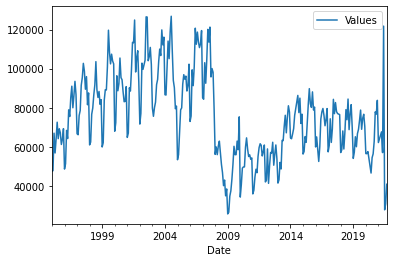

In [33]:
arima_df.plot()

In [ ]:
arima_df.head()

,Values
Date,
2010-04-01,24.734417
2010-05-01,23.804667
2010-06-01,25.176764
2010-07-01,22.336198
2010-08-01,24.832936


In [34]:
auto_arima(arima_df['Values'],seasonal=True).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  321
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -3456.259
Date:                Sat, 12 Feb 2022   AIC                           6918.519
Time:                        14:07:34   BIC                           6929.824
Sample:                             0   HQIC                          6923.033
                                - 321                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6331      0.063     10.057      0.000       0.510       0.756
ma.L1         -0.8879      0.053    -16.742      0.000      -0.992      -0.784
sigma2      1.454e+08   3.12e-10   4.65e+17      0.000    1.45e+08    1.45e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.81   Jarque-Bera (JB):               890.32
Prob(Q):                              0.37   Prob(JB):                         0.00
Heteroskedasticity (H):               1.23   Skew:                            -0.92
Prob(H) (two-sided):                  0.29   Kurtosis:                        10.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.77e+33. Standard errors may be unstable.
"""

In [35]:
auto_arima_summary,arima_df = arima_check(arima_df)

Augmented Dickey-Fuller Test: 
ADF test statistic       -1.861746
p-value                   0.350265
# lags used              16.000000
# observations          304.000000
critical value (1%)      -3.452045
critical value (5%)      -2.871095
critical value (10%)     -2.571861
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary
Augmented Dickey-Fuller Test: 
ADF test statistic       -5.194670
p-value                   0.000009
# lags used              17.000000
# observations          302.000000
critical value (1%)      -3.452190
critical value (5%)      -2.871158
critical value (10%)     -2.571895
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary
Requires differencing of order:  1


In [39]:
hyper_model = 'SARIMAX'
model_dict = {'SARIMAX':(9,1,2), 'ARIMA':(9,1,2)}

In [40]:
# auto_arima_summary,arima_df = arima_check(arima_df)
# print(auto_arima_summary)
if hyper_model == 'ARIMA':
  #For UK hosue price -  (4, 1, 4)
  # For UK TFL - (4, 2, 3)
  order = (4, 1, 4)
  arima_pred_df = arima_train(arima_df,hyper_model,order,None,None)
  metrics_df = metrics(metrics_df,arima_pred_df,hyper_model,order)
elif hyper_model == 'SARIMAX':
  # order = (4,1,2)
  # seasonal_order = (4,1,2,12)
  # 3, 1, 0 - Suggested for after changepoints
  # order = (3,1,0)
  # seasonal_order = (3,1,0,12)

  #Jupyter grid search params for UK housing
  (4, 1, 2, 3, 1, 3, 12)
  #Jupyter grid search params for UK housing - weighted
  (4, 1, 2, 0, 1, 3, 12)	
  #Jupyter grid search params for UK TFL
  (4, 2, 4, 4, 2, 3, 12)
  order = (4, 1, 2)
  seasonal_order = (3, 1, 3 ,12)
  arima_pred_df = arima_train(arima_df,hyper_model,order,seasonal_order,'MS')
  metrics_df = metrics(metrics_df,arima_pred_df,hyper_model,order)
elif hyper_model == 'ALL':
  for key in model_dict.keys():
    arima_pred_df = arima_train(arima_df,key,model_dict[key])
    metrics_df = metrics(metrics_df,arima_pred_df,key,model_dict[key])

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [41]:
metrics_df

,TYPE,ORDER,MAPE,MSE,RMSE,MAE
0,ARIMA,"(4, 1, 4)",0.460757,1.030060e+09,32094.540524,19832.233890
1,SARIMAX,"(4, 1, 2)",0.428392,8.791275e+08,29650.083696,18166.035506


# **Hyper Parameter tuning**

### **ARIMA Parameter Tuning**

In [ ]:
hyper_df = evaluate_models(arima_df,'ARIMA',hyper_df)

In [43]:
print(hyper_df.iloc[0])

TYPE                ARIMA
ORDER           (1, 1, 1)
MAPE             0.392309
MSE      978714291.710513
RMSE         31284.409723
MAE          17749.233939
Name: 6, dtype: object


In [44]:
hyper_df.sort_values(by=['MAE'])

,TYPE,ORDER,MAPE,MSE,RMSE,MAE
6,ARIMA,"(1, 1, 1)",0.392309,9.787143e+08,31284.409723,17749.233939
19,ARIMA,"(3, 1, 4)",0.411569,8.998193e+08,29996.987802,18119.719056
2,ARIMA,"(0, 1, 2)",0.407784,9.799567e+08,31304.259754,18292.183506
8,ARIMA,"(1, 1, 3)",0.409037,9.332361e+08,30548.912830,18342.282708
7,ARIMA,"(1, 1, 2)",0.408694,9.904359e+08,31471.191622,18400.417917
10,ARIMA,"(2, 1, 0)",0.410345,9.797764e+08,31301.380465,18463.198364
14,ARIMA,"(2, 1, 4)",0.416344,8.725709e+08,29539.310879,18523.618179
18,ARIMA,"(3, 1, 3)",0.428656,9.896459e+08,31458.638040,18554.853936
11,ARIMA,"(2, 1, 1)",0.415834,9.870882e+08,31417.959586,18723.357905
12,ARIMA,"(2, 1, 2)",0.431392,1.069894e+09,32709.241359,18732.457251


In [45]:
hyper_df.sort_values(by=['MAPE'])

,TYPE,ORDER,MAPE,MSE,RMSE,MAE
6,ARIMA,"(1, 1, 1)",0.392309,9.787143e+08,31284.409723,17749.233939
2,ARIMA,"(0, 1, 2)",0.407784,9.799567e+08,31304.259754,18292.183506
7,ARIMA,"(1, 1, 2)",0.408694,9.904359e+08,31471.191622,18400.417917
8,ARIMA,"(1, 1, 3)",0.409037,9.332361e+08,30548.912830,18342.282708
10,ARIMA,"(2, 1, 0)",0.410345,9.797764e+08,31301.380465,18463.198364
19,ARIMA,"(3, 1, 4)",0.411569,8.998193e+08,29996.987802,18119.719056
21,ARIMA,"(4, 1, 1)",0.415409,9.480858e+08,30791.002451,18769.592819
11,ARIMA,"(2, 1, 1)",0.415834,9.870882e+08,31417.959586,18723.357905
14,ARIMA,"(2, 1, 4)",0.416344,8.725709e+08,29539.310879,18523.618179
4,ARIMA,"(0, 1, 4)",0.416364,9.257982e+08,30426.932472,18887.650066


### **SARIMA Parameter Tuning**

In [ ]:
hyper_df = evaluate_models_SARIMAX(arima_df,'SARIMAX',hyper_df)
print(hyper_df.iloc[0])

In [ ]:
hyper_df.sort_values(by=['MAPE'])

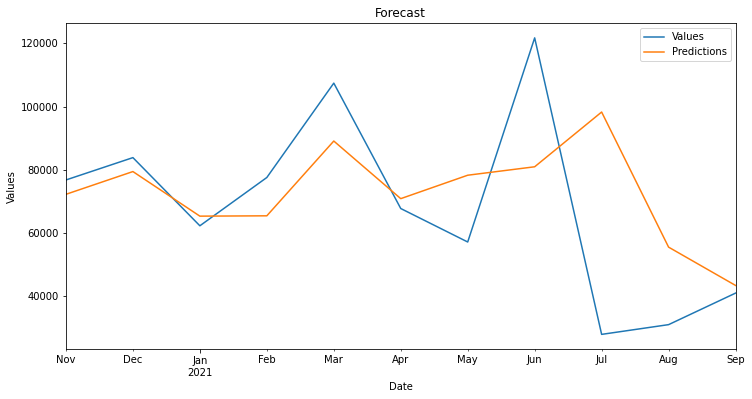

In [ ]:
pred_plot(arima_pred_df)

# **Prophet**

In [53]:
prophet_pred_df, metrics_df = prophet_base_model(df,metrics_df)

In [46]:
def prophet_base_model(input_df,metrics_df):
  prophet_forecast = prophet_model(input_df)
  index = len(prophet_forecast) - 11
  prophet_forecast = prophet_forecast[index:].rename(columns={'ds':'Date','yhat':'Predictions'})
  prophet_pred_df = prophet_forecast[['Date','Predictions']]
  prophet_metrics_df = df[index:]
  prophet_metrics_df = prophet_metrics_df.merge(prophet_pred_df, on='Date', how='left')
  metrics_df = metrics(metrics_df,prophet_metrics_df,'Prophet',None)
  return prophet_metrics_df,metrics_df

In [48]:
def prophet_model(input_df):
  index = len(input_df) - 11
  train_df = input_df[:index].rename(columns={'Date':'ds', 'Values':'y'})
  default_params = {  
    'changepoint_prior_scale': 0.05,
    'changepoint_range' : 0.8,
    'seasonality_prior_scale': 10.0,
  }

  #UK House
  # best_params = {
  #     'changepoint_prior_scale': 0.1,
  #   'changepoint_range' : 0.8,
  #   'seasonality_prior_scale': 0.01,
  # }

  #TFL
  best_params = {
      'changepoint_prior_scale': 0.01,
    'changepoint_range' : 0.85,
    'seasonality_prior_scale': 0.01,
  }
  #UK House
  changepoints_params = {
      'changepoint_prior_scale': 0.1,
      'changepoint_range' : 0.8,
      'seasonality_prior_scale': 0.01,
      'changepoints' : ['2002-12-01','2007-11-01','2007-12-01','2020-03-01'],
  }
  # UK House Weights
  # best_params = {
  #     'changepoint_prior_scale': 0.1,
  #     'changepoint_range' : 0.82,
  #     'seasonality_prior_scale': 0.01,
  #     # 'changepoints' : ['2002-12-01','2007-11-01','2007-12-01','2020-03-01'],
  # }

  #TFL
  # changepoints_params = {
  #     'changepoint_prior_scale': 0.01,
  #     'changepoint_range' : 0.8,
  #     'seasonality_prior_scale': 0.01,
  #     'changepoints' : ['2020-02-01','2020-03-01','2020-04-01','2020-05-01'],
  # }

  # changepoints_arr = ['2002-12-01','2007-11-01','2007-12-01','2020-03-01']
  model , forecast = model_train_predict(train_df,best_params)
  return forecast

In [49]:
#Train and fit the model
def model_train_predict(input_df,params):
  m = None
  m = Prophet( seasonality_mode='additive', 
            yearly_seasonality= True,
            daily_seasonality = False,
            weekly_seasonality = False,
            **params)
  m.fit(input_df)
  # Forcasting into the future
  future = m.make_future_dataframe(periods=11,freq='MS')
  # future = m.make_future_dataframe(periods=11,freq='W-Sat')
  forecast = m.predict(future)
  return m, forecast

In [50]:
metrics_df

,TYPE,ORDER,MAPE,MSE,RMSE,MAE
0,ARIMA,"(4, 1, 4)",0.460757,1.030060e+09,32094.540524,19832.233890
1,SARIMAX,"(4, 1, 2)",0.428392,8.791275e+08,29650.083696,18166.035506


In [54]:
test_df = arima_preprocess(prophet_pred_df)

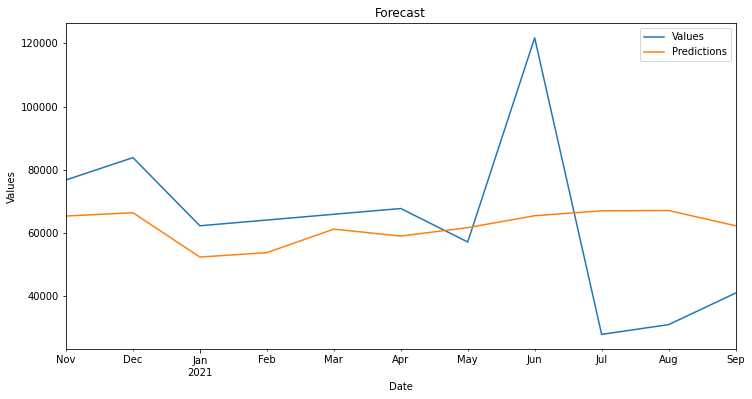

In [55]:
pred_plot(test_df)

In [56]:
metrics_df

,TYPE,ORDER,MAPE,MSE,RMSE,MAE
0,ARIMA,"(4, 1, 4)",0.460757,1.030060e+09,32094.540524,19832.233890
1,SARIMAX,"(4, 1, 2)",0.428392,8.791275e+08,29650.083696,18166.035506
2,Prophet,None,0.410150,6.562297e+08,25616.980095,19993.828822


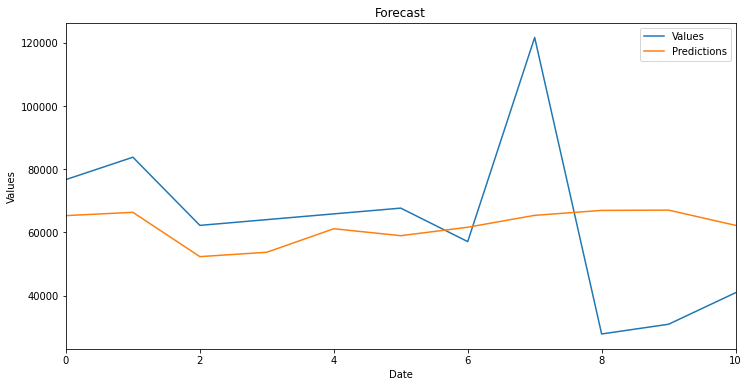

In [57]:
pred_plot(prophet_pred_df)